In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from collections import defaultdict

S:\anaconda3\envs\hh_casualml_test\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# ================ 1. ЗАГРУЗКА ДАННЫХ ================
print("Загрузка данных...")
triggers = pd.read_csv('triggers.csv', parse_dates=['date'])
actions = pd.read_csv('actions.csv', parse_dates=['date'])

# Определяем max_date для окон
max_date = max(triggers['date'].max(), actions['date'].max())

Загрузка данных...


In [3]:
# ================ 2. ПОДГОТОВКА ПРИЗНАКОВ ================
print("Подготовка признаков...")

def aggregate_features(df, by, date_col, windows, col, max_date):
    """Агрегация признаков по временным окнам"""
    chunks = []
    for w in tqdm(windows, desc=f'agg {col} windows'):
        start = max_date - pd.Timedelta(days=w)
        df_w = df[df[date_col] >= start]
        agg = (
            df_w
            .groupby(by)[col]
            .agg(count='count', unique='nunique')
            .rename(columns={
                'count': f'count_{w}d',
                'unique': f'unique_{w}d'
            })
        )
        chunks.append(agg)
    return pd.concat(chunks, axis=1).fillna(0)

# Строим фичи из triggers
windows = [7, 14, 30]
f_tr = aggregate_features(triggers, 'guid', 'date', windows, 'trigger', max_date)
f_ty = aggregate_features(triggers, 'guid', 'date', windows, 'type', max_date)

# Добавляем префиксы
f_tr = f_tr.add_prefix('tr_')
f_ty = f_ty.add_prefix('ty_')

# Агрегация признаков из actions
act_agg = (
    actions
    .groupby('guid')
    .agg(
        shows_count=('date', 'count'),
        positive_shows=('result', 'sum'),
        last_show=('date', 'max')
    )
)
act_agg['days_since_last_show'] = (
        max_date - act_agg['last_show']
).dt.days.fillna(999)

# Объединяем все признаки
features = (
    f_tr
    .join(f_ty, how='outer')
    .join(act_agg, how='outer')
    .fillna({
        'shows_count': 0,
        'positive_shows': 0,
        'days_since_last_show': 999
    })
)
features['user_ctr'] = (
        features['positive_shows'] / features['shows_count'].replace(0, 1)
)

# Добавляем recency из triggers
last_visit = triggers.groupby('guid')['date'].max()
features['days_since_last_visit'] = (
        max_date - last_visit
).dt.days.fillna(999)

# Сохраняем признаки
features.reset_index().to_csv('features_xgb.csv', index=False)
print(f"Признаки сохранены, размер: {features.shape}")

Подготовка признаков...


agg trigger windows:   0%|          | 0/3 [00:00<?, ?it/s]

agg type windows:   0%|          | 0/3 [00:00<?, ?it/s]

Признаки сохранены, размер: (1009806, 18)


In [4]:
# ================ 3. ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ ================
print("Подготовка данных для обучения...")

# Разделим данные на две группы по времени (не случайно!)
# Берем первые 80% дней для обучения, последние 20% для тестирования
print("Разделение данных по времени...")
all_dates = sorted(actions['date'].unique())
split_idx = int(len(all_dates) * 0.8)
train_dates = all_dates[:split_idx]
test_dates = all_dates[split_idx:]

# Формируем выборки с учетом временного разделения
train_actions = actions[actions['date'].isin(train_dates)]
test_actions = actions[actions['date'].isin(test_dates)]

# Соединяем признаки с метками
feat = pd.read_csv('features_xgb.csv')

# Определяем признаки, которые будем использовать 
# (исключаем признаки, которые могут быть недоступны в реальном времени)
available_features = [
    'tr_count_7d', 'tr_unique_7d', 'tr_count_14d', 'tr_unique_14d',
    'tr_count_30d', 'tr_unique_30d', 'ty_count_7d', 'ty_unique_7d',
    'ty_count_14d', 'ty_unique_14d', 'ty_count_30d', 'ty_unique_30d',
    'days_since_last_visit'
]

# Создаем тренировочную и тестовую выборки
train_df = feat.merge(train_actions[['guid', 'date', 'result']], on='guid')
test_df = feat.merge(test_actions[['guid', 'date', 'result']], on='guid')

# Проверяем, что в тестовых данных нет информации из обучающей выборки
test_df = test_df.drop(columns=[
    'shows_count', 'positive_shows', 'user_ctr', 'days_since_last_show'
])

Подготовка данных для обучения...
Разделение данных по времени...


In [5]:
train_df = train_df.fillna(-1)

In [6]:
# Готовим X и y
X_train = train_df[available_features]
y_train = train_df['result']
X_test = test_df[available_features]
y_test = test_df['result']

In [7]:
y_train.value_counts(normalize=True)

result
0    0.970426
1    0.029574
Name: proportion, dtype: float64

In [8]:
# ================ 4. ОБУЧЕНИЕ МОДЕЛИ ================
print("Обучение модели...")

# Параметры для балансировки классов
ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Создаем разбиение для валидации
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

Обучение модели...


In [9]:
# # Обучение модели с валидацией для предотвращения переобучения
# model = XGBClassifier(
#     eval_metric='auc',
#     scale_pos_weight=ratio,
#     n_estimators=5000,
#     max_depth=7,
#     learning_rate=0.005,
#     early_stopping_rounds=100,  # Останавливаемся, если валидационная метрика не улучшается
#     device="gpu"
# )
# model.fit(
#     X_smote, y_smote,
#     eval_set=[(X_val, y_val)],
#     verbose=100
# )
# 
# # Калибровка вероятностей для получения более реалистичных прогнозов
# calibrated_model = CalibratedClassifierCV(
#     model,
#     method='isotonic',
#     cv='prefit'
# )
# calibrated_model.fit(X_val, y_val)

In [10]:
# # SMOTE
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=42)
# X_smote, y_smote = smote.fit_resample(X_train_split, y_train_split)

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_c = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 10, n_jobs=20, class_weight={0: 5, 1:1}, warm_start = False)
rf_c.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 5, 1: 1}, max_depth=10, n_jobs=20,
                       random_state=42)

In [18]:
from sklearn.metrics import precision_recall_curve, auc, f1_score
from sklearn.model_selection import cross_val_predict

# Получение предсказаний через кросс-валидацию
y_pred_proba = cross_val_predict(rf_c, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# PR-кривая
precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.4f}")

PR-AUC: 0.0645


In [19]:
# ================ 5. ОЦЕНКА МОДЕЛИ ================
print("Оценка модели...")

# Предсказания на тестовой выборке
y_proba = rf_c.predict_proba(X_test)[:, 1]
roc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC на тестовой выборке: {roc:.4f}")

Оценка модели...
ROC-AUC на тестовой выборке: 0.6701


In [20]:
# ================ 6. СИМУЛЯЦИЯ КАМПАНИИ С РЕАЛЬНЫМИ ДАННЫМИ ================
print("Симуляция кампании с реальными данными...")

def simulate_campaign_with_real_data(thresholds, freq_days=14):
    """
    Оптимизированная симуляция кампании с использованием реальных данных конверсии
    """
    results = []

        # 1. Предварительный расчет вероятностей для всех пользователей (оптимизировано)
    print("Расчет вероятностей для всех пользователей...")
    
    # Берем только уникальные комбинации guid + признаки (без группировки)
    unique_users = test_df.drop_duplicates('guid')
    print(f"Количество уникальных пользователей: {len(unique_users)}")
    
    # Подготавливаем данные для пакетного предсказания
    X_pred = unique_users[available_features].values
    
    # Пакетное предсказание (гораздо быстрее, чем поштучное)
    with tqdm(total=1, desc="Batch prediction") as pbar:
        probas = rf_c.predict_proba(X_pred)[:, 1]
        pbar.update(1)
    
    # Создаем словарь guid -> вероятность
    guid_to_prob = dict(zip(unique_users['guid'], probas))

    # 2. Подготовка данных о событиях
    print("Подготовка данных о посещениях и конверсиях...")
    # Создаем и заполняем структуру: guid -> список (date, result)
    guid_results = defaultdict(list)
    for _, row in test_actions.iterrows():
        guid = row['guid']
        # Добавляем только тех пользователей, для которых есть прогноз
        if guid in guid_to_prob:
            guid_results[guid].append((row['date'], row['result']))

    # 3. Предварительная подготовка всех событий с вероятностями
    print("Формирование полного списка событий...")
    all_events = []
    for guid, events in guid_results.items():
        prob = guid_to_prob[guid]
        for date, result in events:
            all_events.append((date, guid, result, prob))

    # 4. Сортируем все события по дате (один раз)
    all_events.sort()

    # 5. Запускаем симуляцию для каждого порога
    for threshold in tqdm(thresholds, desc="Симуляция для порогов"):
        # Предварительно фильтруем события по порогу
        filtered_events = [
            (date, guid, result) for date, guid, result, prob in all_events
            if prob >= threshold
        ]

        # Симуляция показов
        total_shows = 0
        total_conversions = 0
        last_shown = {}  # guid -> дата последнего показа

        # Проходим по предварительно отфильтрованным событиям
        for date, guid, result in filtered_events:
            # Проверяем ограничение частоты
            if guid in last_shown:
                days_since_last = (date - last_shown[guid]).days
                if days_since_last < freq_days:
                    continue

            # Показываем баннер
            total_shows += 1
            last_shown[guid] = date

            # Учитываем реальный результат
            if result == 1:
                total_conversions += 1

        # Рассчитываем метрики
        spend = total_shows  # $1 за показ
        revenue = total_conversions * 5  # $5 за конверсию
        balance = revenue - spend
        turnover = revenue + spend

        results.append({
            'threshold': threshold,
            'shows': total_shows,
            'conversions': total_conversions,
            'spend': spend,
            'revenue': revenue,
            'balance': balance,
            'turnover': turnover,
            'conv_rate': total_conversions / total_shows if total_shows > 0 else 0
        })

    return pd.DataFrame(results)

# Генерируем список порогов для проверки
thresholds = np.linspace(0.001, 0.95, 19)  # от 0.05 до 0.95 с шагом 0.05
simulation_results = simulate_campaign_with_real_data(thresholds)

Симуляция кампании с реальными данными...
Расчет вероятностей для всех пользователей...
Количество уникальных пользователей: 107461


Batch prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Подготовка данных о посещениях и конверсиях...


S:\anaconda3\envs\hh_casualml_test\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Формирование полного списка событий...


Симуляция для порогов:   0%|          | 0/19 [00:00<?, ?it/s]

In [21]:
# ================ 7. АНАЛИЗ РЕЗУЛЬТАТОВ ================
print("Анализ результатов симуляции...")

# Отбираем только варианты с положительным балансом
profitable = simulation_results[simulation_results['balance'] >= 0]

if len(profitable) > 0:
    # Находим порог с максимальным оборотом при положительном балансе
    best_row = profitable.loc[profitable['turnover'].idxmax()]
    best_threshold = best_row['threshold']

    print("\n=== ОПТИМАЛЬНЫЙ ПОРОГ ДЛЯ МАКСИМИЗАЦИИ ОБОРОТА ===")
    print(f"Порог вероятности: {best_threshold:.4f}")
    print(f"Показы: {best_row['shows']}")
    print(f"Конверсии: {best_row['conversions']}")
    print(f"Расходы: ${best_row['spend']}")
    print(f"Доходы: ${best_row['revenue']}")
    print(f"Баланс: ${best_row['balance']}")
    print(f"Оборот: ${best_row['turnover']}")
    print(f"Конверсия: {best_row['conv_rate']:.2%}")
else:
    print("Не найдено вариантов с положительным балансом. Попробуйте другие параметры модели.")

Анализ результатов симуляции...

=== ОПТИМАЛЬНЫЙ ПОРОГ ДЛЯ МАКСИМИЗАЦИИ ОБОРОТА ===
Порог вероятности: 0.3173
Показы: 9.0
Конверсии: 2.0
Расходы: $9.0
Доходы: $10.0
Баланс: $1.0
Оборот: $19.0
Конверсия: 22.22%



Анализ завершен. Результаты сохранены в simulation_results.png


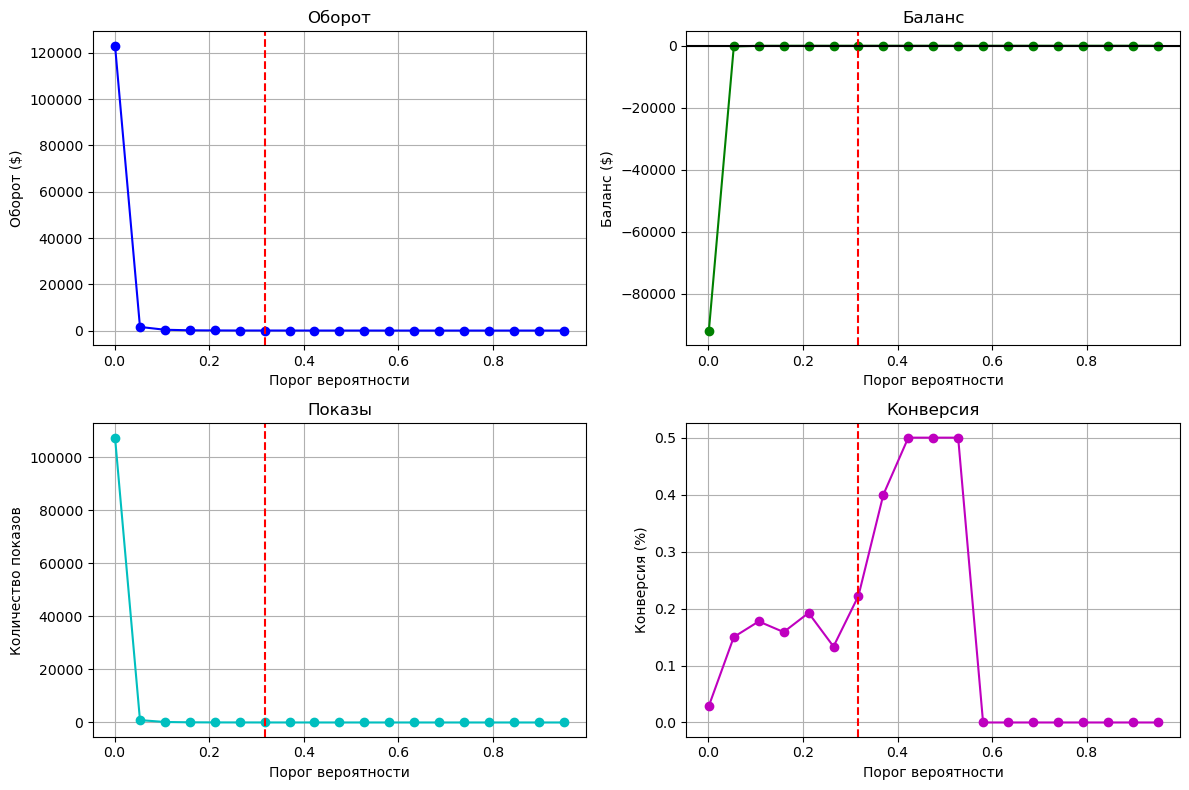

In [22]:
# ================ 8. ВИЗУАЛИЗАЦИЯ ================
plt.figure(figsize=(12, 8))

# График оборота
plt.subplot(2, 2, 1)
plt.plot(simulation_results['threshold'], simulation_results['turnover'], 'b-', marker='o')
plt.axvline(x=best_threshold, color='r', linestyle='--')
plt.title('Оборот')
plt.xlabel('Порог вероятности')
plt.ylabel('Оборот ($)')
plt.grid(True)

# График баланса
plt.subplot(2, 2, 2)
plt.plot(simulation_results['threshold'], simulation_results['balance'], 'g-', marker='o')
plt.axvline(x=best_threshold, color='r', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.title('Баланс')
plt.xlabel('Порог вероятности')
plt.ylabel('Баланс ($)')
plt.grid(True)

# График количества показов
plt.subplot(2, 2, 3)
plt.plot(simulation_results['threshold'], simulation_results['shows'], 'c-', marker='o')
plt.axvline(x=best_threshold, color='r', linestyle='--')
plt.title('Показы')
plt.xlabel('Порог вероятности')
plt.ylabel('Количество показов')
plt.grid(True)

# График конверсии
plt.subplot(2, 2, 4)
plt.plot(simulation_results['threshold'], simulation_results['conv_rate'], 'm-', marker='o')
plt.axvline(x=best_threshold, color='r', linestyle='--')
plt.title('Конверсия')
plt.xlabel('Порог вероятности')
plt.ylabel('Конверсия (%)')
plt.grid(True)

plt.tight_layout()
plt.savefig('simulation_results.png')

print("\nАнализ завершен. Результаты сохранены в simulation_results.png")